# Conversational Wikidata RAG Agent
A conversational application using LangChain's prebuilt ReAct agent that can query Wikidata for up-to-date facts and incorporate them into generated responses.

- accesses data via the Wikidata SPARQL endpoint to support inference 
- supports return of implicit facts in the dataset not explicitly on individual records
- defines a narrow scope of functionality in order to deal with the wide ranging schema of Wikidata content

This exercise builds on the `conversational-rag-agent.ipynb` exercise and adds in:
- custom tool definition
- multiple tool options
- tool parameters
- scope guardrails

This particular example creates an agent designed to answer questions about the age and country of origin of medalists in the 2024 Summer Olympics. Sample questions with correct answers (according to Wikidata) are provided below. Verify additional questions (including those that reflect updated data) with [this SPARQL query](https://query.wikidata.org/#%23title%3A%2010%20youngest%20medalists%20of%20the%202024%20Summer%20Olympic%20Games%0A%23description%3A%20Return%20their%20country%2C%20sport%2C%20event%2C%20age%20at%20the%20time%20of%20the%20games%2C%20and%20medal%0APREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0APREFIX%20p%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX%20ps%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fstatement%2F%3E%0APREFIX%20pq%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fqualifier%2F%3E%0A%0A%0ASELECT%20DISTINCT%20%3FsportLabel%20%3FeventLabel%20%3FparticipantLabel%20%3Fage%20%3FcountryLabel%20%3FawardLabel%0A%0AWHERE%20%7B%0A%20%20%3Fsport%20wdt%3AP31%20wd%3AQ26132862%3B%20%20%23%20item%20that%20is%20an%20instance%20of%20olympic%20sports%20discipline%0A%20%20%20%20wdt%3AP361%2B%20wd%3AQ995653%3B%20%20%20%20%20%20%20%23%20and%20part%20of%202024%20games%2C%20or%20part%20of%20an%20event%20that%20was%0A%20%20%20%20wdt%3AP527%20%3Fevent.%20%20%20%20%20%20%20%20%20%20%20%20%23%20and%20hasParts%20that%20are%20individual%20events%0A%20%20%20%20%23%20not%20all%20disciplines%20have%20events%20listed%3B%20this%20list%20will%20be%20missing%20some%20categories%0A%20%20%0A%20%20%23%20get%20full%20statements%20about%20the%20participatns%2C%20participating%20teams%2C%20and%20winners%20of%20those%20events%0A%20%20%3Fevent%20p%3AP710%20%7C%20p%3AP1923%20%7C%20p%3AP1346%20%3FparticipantStatement.%0A%0A%20%20%3FparticipantStatement%20ps%3AP1346%20%7C%20ps%3AP710%20%7C%20ps%3AP1923%20%3Fparticipant%3B%20%20%23%20get%20the%20participant%0A%20%20%20%20%20%20pq%3AP166%20%7C%20pq%3AP2868%20%3Faward.%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23%20and%20that%20participant%27s%20award%0A%0A%20%20%3Fparticipant%20wdt%3AP1532%20%3Fcountry%3B%20%20%20%23%20Get%20the%20country%20the%20participant%20competed%20for%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP569%20%3Fdob.%20%20%20%20%20%20%20%20%23%20and%20their%20date%20of%20birth%0A%0A%20%20%23%20Bind%20closing%20ceremony%20date%20as%20%3Fclosing%0A%20%20BIND%28%222024-08-11%22%5E%5Exsd%3Adate%20AS%20%3Fclosing%29%0A%0A%20%20%23%20Calculate%20approximate%20age%20by%20subtracting%20the%20closing%20date%20from%20the%20participant%27s%20date%20of%20birth%0A%20%20BIND%28%0A%20%20%20%20FLOOR%28%0A%20%20%20%20%20%20%28YEAR%28%3Fclosing%29%20-%20YEAR%28%3Fdob%29%29%20-%0A%20%20%20%20%20%20%20%20IF%20%28MONTH%28%3Fclosing%29%20%3C%20MONTH%28%3Fdob%29%20%7C%7C%20%28MONTH%28%3Fclosing%29%20%3D%20MONTH%28%3Fdob%29%20%26%26%20DAY%28%3Fclosing%29%20%3C%20DAY%28%3Fdob%29%29%2C%201%2C%200%29%0A%20%20%20%20%29%20AS%20%3Fage%29%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%23%20Use%20SERVICE%20wikibase%3Alabel%20to%20fetch%20labels%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%7D%0A%7D%0AORDER%20BY%20%3Fage%0A%23%20LIMIT%2010%0A). 


In [9]:
%pip install --upgrade --quiet langchain
%pip install -qU langchain-openai
%pip install python-dotenv
%pip install langchain_core
%pip install langgraph
%pip install sparqlwrapper

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# Load environment variables from .env file
load_dotenv()

# Change the temperature to see how much the model varies outputs
temp = 0

llm = ChatOpenAI(model="gpt-4o-mini", temperature=temp, api_key=os.getenv("OPENAI_API_KEY"))

# Enable tracing with LangSmith
# LANGCHAIN_API_KEY environment variable is set in .env
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "wikidata-rag"

# Set the USER_AGENT environment variable
os.environ['USER_AGENT'] = 'conversational-rag-agent'

## Create Wikidata tool

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
from langchain.tools import tool
from typing import Literal

@tool
def wikidataOlympicMedalistQuery(direction: Literal["ASC", "DESC"] = "ASC", limit: int = 10) -> str:
    """This tool returns data on the youngest medalists of the 2024 Summer Olympic Games on Wikidata and return their country, sport, event, age at the time of the games, and what medal they won.
    
    Args:
        direction (Literal["ASC", "DESC"]): The direction to sort the results. Default is "ASC".
        limit (int): The number of results to return. Default is 10. If you don't see any relevant results, try increasing the limit."""
    
    endpoint_url = "https://query.wikidata.org/sparql"

    query = f"""#title: 10 youngest medalists of the 2024 Summer Olympic Games
    #description: Return their country, sport, event, age at the time of the games, and medal
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    PREFIX p: <http://www.wikidata.org/prop/>
    PREFIX ps: <http://www.wikidata.org/prop/statement/>
    PREFIX pq: <http://www.wikidata.org/prop/qualifier/>


    SELECT DISTINCT ?sportLabel ?eventLabel ?participantLabel ?age ?countryLabel ?awardLabel

    WHERE {{
    ?sport wdt:P31 wd:Q26132862;    # item that is an instance of olympic sports discipline
        wdt:P361+ wd:Q995653;       # and part of 2024 games, or part of an event that was
        wdt:P527 ?event.            # and hasParts that are individual events
                                    # not all disciplines have events listed: this list will be missing some categories

    # get full statements about the participants, participating teams, and winners of those events
    ?event p:P710 | p:P1923 | p:P1346 ?participantStatement.

    ?participantStatement ps:P1346 | ps:P710 | ps:P1923 ?participant;  # get the participant
        pq:P166 | pq:P2868 ?award.                                     # and that participant's award

    ?participant wdt:P1532 ?country;   # Get the country the participant competed for
                wdt:P569 ?dob.         # and their date of birth

    # Bind closing ceremony date as ?closing
    BIND("2024-08-11"^^xsd:date AS ?closing)

    # Calculate approximate age by subtracting the closing date from the participant's date of birth
    BIND(
        FLOOR(
        (YEAR(?closing) - YEAR(?dob)) -
            IF (MONTH(?closing) < MONTH(?dob) || (MONTH(?closing) = MONTH(?dob) && DAY(?closing) < DAY(?dob)), 1, 0)
        ) AS ?age)
                
    # Use SERVICE wikibase:label to fetch labels
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    ORDER BY {direction}(?age)
    LIMIT {limit}
    """

    def get_results(endpoint_url, query):
        user_agent = "LlmIntegration/0.0 (https://github.com/andybywire/)"
        sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()

    results = get_results(endpoint_url, query)

    def create_statements(results):
        statements = []
        if results:
            for result in results["results"]["bindings"]:
                statement = f"{result['participantLabel']['value']}, age {result['age']['value']} from {result['countryLabel']['value']}, won a {result['awardLabel']['value'].replace('Olympic','')} in {result['eventLabel']['value'].replace(' – ',', ')}."
                statements.append(statement)
        return statements

    return create_statements(results)

tools = [wikidataOlympicMedalistQuery]

## Create agent with conversation memory

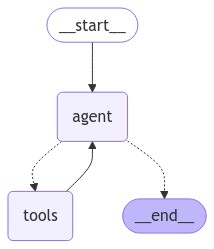

In [3]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

prompt = """You are an assistant designed for answering questions 
about the results of the 2024 Summer Olympics. Use the tools at your 
disposal to answer the question. If the data provided doesn't answer 
the question, try to tool again with a larger return limit or a 
different sort order. If you still can't find the the answer, 
say that you don't know. Keep your answers concise and limit your 
responses to 3-4 sentences or brief lists."""

agent_executor = create_react_agent(llm, tools, state_modifier=prompt, checkpointer=memory)

from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

## Invoke the agent

In [ ]:
import uuid
from langchain_core.messages import HumanMessage
from IPython.display import display, Markdown

# create a new id each time this cell is run
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    question = input("> ")
    if question == "q": # type 'q' to quit
        break
    response = agent_executor.invoke(
        {"messages": [HumanMessage(content=question)]}, config=config
    )
    display(Markdown(f"""**Question:** {question}   
                         **Response:** {response["messages"][-1].content}"""))

# Sample questions & correct answers
#
# Who were the youngest medalists at the 2024 Summer Olympics and what did they win?
#   - 1. Ban Hyo-jin (South Korea) - age 16, gold medal in shooting (women's 10 metre air rifle).
#   - 2. Dominika Banevič (Lithuania) - age 17, silver medal in breaking (B-girls).
#   - 3. Darja Varfolomeev (Germany) - age 17, gold medal in gymnastics (women's rhythmic individual all-around).
#   - 4. Quan Hongchan (People's Republic of China) - age 17, gold medal in diving (women's 10 metre platform). 
# What countries were the youngest medalists at the 2024 Summer Olympics from?
#   - South Korea, Lithuania, Germany, People's Republic of China, Russia
# Who was the youngest medalist from Japan in the 2024 Summer Olympic 
#   - Men's tennis singles, Carlos Alcara
# Who was the youngest medalist at the Summer 2024 Olympics from a country in Africa and what event did they win?
#   - Emmanuel Wanyonyi from Kenya, who won a gold medal in athletics (men's 800 metres)
# Who was the oldest medalist at the 2024 Olympics from a country in Africa?
#   - Hellen Obiri from Kenya, who won a bronze medal in athletics (women's marathon)
# Who was the youngest fencing medalist at the 2024 Olympic Games?
#  - As of 9.13.24, this should return no results: fencing data is not yet available in Wikidata

In [ ]:
# inspect the response object
import json
print(json.dumps(response, indent=4, default=str))